In [1]:
!pip install sparqlwrapper
!pip install pandas
%pip install aiohttp aiofiles nest_asyncio

   ---------------------------------------- 0.0/363.4 kB ? eta -:--:--
   ---------- ----------------------------- 92.2/363.4 kB 2.6 MB/s eta 0:00:01
   --------------------------------- ------ 307.2/363.4 kB 3.2 MB/s eta 0:00:01
   ---------------------------------------- 363.4/363.4 kB 3.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/50.5 kB ? eta -:--:--
   ---------------------------------------- 50.5/50.5 kB ? eta 0:00:00
   ---------------------------------------- 0.0/76.4 kB ? eta -:--:--
   ---------------------------------------- 76.4/76.4 kB 4.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os

# On vérifie si le dossier "images" est bien créé
try:
    os.mkdir('images')
except:
    pass

In [13]:
import sys
from SPARQLWrapper import SPARQLWrapper, JSON
import requests
import shutil
import os
import pandas as pd
import nest_asyncio
import asyncio
import aiofiles
import aiohttp
from pandas import DataFrame

endpoint_url = "https://query.wikidata.org/sparql"

# Requête pour récupérer les montagnes
query = """
    SELECT ?qid ?itemLabel ?part ?partLabel ?image WHERE {
      ?item wdt:P31 wd:Q8502 .
      ?item wdt:P361 ?part .
      ?item wdt:P18 ?image .

    BIND(STRAFTER(STR(?item), STR(wd:)) AS ?qid) .
    SERVICE wikibase:label { #BabelRainbow
        bd:serviceParam wikibase:language "[AUTO_LANGUAGE],fr"
    }

    }
    LIMIT 100
"""

nest_asyncio.apply()

dl_dir = "./images"
dl_sem = asyncio.Semaphore(4) # On va lancer 4 tâches en parallèle

async def download_images(df: DataFrame):
    download_tasks = []
    print(f"Téléchargement de {len(df)} images...")
    # Pour chaque élément de notre DataFrame
    for _, row in df.iterrows():
        filename = f"{row['qid']}.jpg"
        url = row["image"]
        # On ajoute la tâche de téléchargement de l'image
        download_tasks.append(download_image(url, filename))
    # On exécute les tâches (téléchargement des images)
    await asyncio.gather(*download_tasks)

async def download_image(url, filename):
    headers = {"User-Agent": "Mozilla/5.0"}
    # On vérifie si l'image existe déja
    if os.path.exists(f"{dl_dir}/{filename}"):
        return
    # Sinon on télécharge l'image de manière asynchrone
    async with aiohttp.ClientSession() as session:
            async with dl_sem:
                async with session.get(url, allow_redirects=True, headers=headers) as res:
                    if res.status != 200:
                        print(f"Impossible de télécharger l'image à l'url {url} (code {res.status})")
                        return
                    # On enregistre l'image
                    async with aiofiles.open(f"{dl_dir}/{filename}", "wb") as f:
                        await f.write(await res.read())
                        await f.close()

def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (
        sys.version_info[0],
        sys.version_info[1],
    )
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()

montains = []
results = get_results(endpoint_url, query)

# On traite les données récupérées de notre requête
for result in results["results"]["bindings"]:
    element = []
    element.append(result["qid"]["value"])
    element.append(result["itemLabel"]["value"])
    element.append(result["image"]["value"])
    element.append(result["partLabel"]["value"])
    montains.append(element)
    
dataframe = pd.DataFrame(montains, columns=["qid", "itemLabel", "image", "partLabel"])

dataframe

,qid,itemLabel,image,partLabel
0,Q16540,Breithorn,http://commons.wikimedia.org/wiki/Special:File...,frontière entre l'Italie et la Suisse
1,Q16546,Six Madun,http://commons.wikimedia.org/wiki/Special:File...,Q19284304
2,Q16585,Gäbris,http://commons.wikimedia.org/wiki/Special:File...,Préalpes suisses
3,Q16617,Piz Terri,http://commons.wikimedia.org/wiki/Special:File...,Ligne de partage des eaux entre mer Adriatique...
4,Q16632,Kronberg,http://commons.wikimedia.org/wiki/Special:File...,Q620982
...,...,...,...,...
95,Q30533,dôme de Rochefort,http://commons.wikimedia.org/wiki/Special:File...,ligne de partage des eaux entre mer Adriatique...
96,Q30541,dent du Géant,http://commons.wikimedia.org/wiki/Special:File...,frontière entre la France et l'Italie
97,Q30541,dent du Géant,http://commons.wikimedia.org/wiki/Special:File...,ligne de partage des eaux entre mer Adriatique...
98,Q35366,Q35366,http://commons.wikimedia.org/wiki/Special:File...,Alpes d'Arrochar


In [14]:
# On lance le téléchargement des images
asyncio.run(download_images(dataframe))

Téléchargement de 100 images...


In [28]:
from concurrent.futures import Future, ThreadPoolExecutor, wait
from dataclasses import dataclass, field
import json
import math
from PIL import Image, ExifTags, TiffImagePlugin
from pprint import pprint
import numpy
from sklearn.cluster import KMeans
from pandas import DataFrame, Series
import asyncio
from enum import Enum

# Seuil d'une grande image (1280 x 720)
IMG_BIG_RES = 921600

# Seuil d'une image moyenne (480 x 360)
IMG_MED_RES = 172800

executor = ThreadPoolExecutor(max_workers=8) # On traire 8 images à la fois

# On définit le contenu de notre fichier JSON (exif + tags custom)
@dataclass
class SubjectMetadata(object):
    exif_tags: dict[str, str] = field(default_factory=dict)
    subject_tags: dict[str, str] = field(default_factory=dict)
    width: int = field(default_factory=int)
    height: int = field(default_factory=int)
    image_size: str = field(default_factory=str)
    color_mode: str = field(default_factory=str)
    dominant_colors: list[str] = field(default_factory=list)

image_metadata: dict[str, SubjectMetadata] = dict()
image_metadata_lock: dict[str, asyncio.Lock] = dict()

# Création de l'élément Json + Ajout de la tâche de traitement de l'image
def parse_metadata_for_subjects(df: DataFrame):
    futures: list[Future] = [ ]
    # Pour chaque élément de notre DataFrame
    for _, subject in df.iterrows():
        qid = subject["qid"]
        # On créé un élément Json
        image_metadata[qid] = SubjectMetadata()
        image_metadata[qid].subject_tags = subject["partLabel"]
        image_metadata_lock[qid] = asyncio.Lock()
        # On ajoute la tâche de traitement de l'image
        futures.append(executor.submit(async_wrapper_parse_metadata_for_subeject, subject))
    print(futures)
    wait(futures)

def async_wrapper_parse_metadata_for_subeject(subject: Series):
    # Exécution des tâches
    asyncio.run(parse_metadata_for_subject(subject))

# Traitement d'une image
async def parse_metadata_for_subject(subject: Series):
    tasks = []
    qid = subject["qid"]
    # On récupère l'image grace à l'id de la montagne
    filename = f"{qid}.jpg"
    full_path = f"{dl_dir}/{filename}"
    image = Image.open(full_path)
    tasks.append(parse_exif_tags_for_subject(qid, image))
    tasks.append(parse_image_metadata_for_subject(qid, image))
    await asyncio.gather(*tasks)

# Ajout de nos tags custom dans notre élément Json
async def parse_image_metadata_for_subject(id: str, image: Image.Image) -> None:
    global image_metadata
    width = image.width
    height = image.height
    # On réduit la taille de l'image pour fluidifier le calcul des couleurs dominantes
    image = image.resize(size=(math.ceil(image.width/10), math.ceil(image.height/10)))
    color_mode = image.mode
    dominant_colors = get_image_dominant_colors(image)
    img_res = width*height
    if img_res >= IMG_BIG_RES:
        image_size = "Big"
    elif img_res >= IMG_MED_RES:
        image_size = "Medium"
    else:
        image_size = "Small"

    async with image_metadata_lock[id]:   
        image_metadata[id].color_mode = color_mode
        image_metadata[id].width = width
        image_metadata[id].height = height
        image_metadata[id].image_size = image_size
        image_metadata[id].dominant_colors = dominant_colors

# Extraction des 3 (par défaut) couleurs dominantes d'une image
def get_image_dominant_colors(image: Image.Image, n: int = 3) -> list[str]:
    numarray = numpy.array(image.getdata(), numpy.uint16)
    clusters = KMeans(n_clusters=n, n_init=2)
    clusters.fit(numarray)
    results = [ "#%02x%02x%02x" % (int(r),int(g),int(b)) for r,g,b in clusters.cluster_centers_ ]
    return results

# Extraction des tags exif d'une image
async def parse_exif_tags_for_subject(id: str, image: Image.Image) -> None:
    global image_metadata
    exif_tags = parse_exif_tags(image)
    async with image_metadata_lock[id]:   
        image_metadata[id].exif_tags = exif_tags

# On rend les tags exif écritables dans un Json
def parse_exif_tags(image: Image.Image) -> dict[str, str]:
    tmp_exif_tags = image.getexif()
    exif_tags = dict()
    if len(tmp_exif_tags) == 0:
        return exif_tags
    for exif_tag, val in tmp_exif_tags.items():
        if exif_tag in ExifTags.TAGS:
            if isinstance(val, bytes):
                d = try_decode(val)
                if isinstance(d, str):
                    val = d
                else:
                    continue
            exif_tag_str = ExifTags.TAGS[exif_tag]
            if isinstance(val, TiffImagePlugin.IFDRational):
                val = float(val)
            exif_tags[exif_tag_str] = val
    return exif_tags

def try_decode(s: bytes) -> type[str | bytes]:
    try:
        return s.decode()
    except:
        return s

parse_metadata_for_subjects(dataframe)
pprint(image_metadata)

[<Future at 0x190279bf5f0 state=running>, <Future at 0x19021a0c950 state=running>, <Future at 0x190279be540 state=running>, <Future at 0x190279bd9d0 state=running>, <Future at 0x190257136e0 state=running>, <Future at 0x190217fa420 state=running>, <Future at 0x190279fa000 state=running>, <Future at 0x190279fb920 state=running>, <Future at 0x190279fbdd0 state=pending>, <Future at 0x190279fbad0 state=pending>, <Future at 0x190279fb6b0 state=pending>, <Future at 0x190279fb770 state=pending>, <Future at 0x190279fb650 state=pending>, <Future at 0x190279f9670 state=pending>, <Future at 0x190279f9640 state=pending>, <Future at 0x190279f9550 state=pending>, <Future at 0x190279f9be0 state=pending>, <Future at 0x190279f9df0 state=pending>, <Future at 0x1902181d7f0 state=pending>, <Future at 0x1902181e960 state=pending>, <Future at 0x1902181e9f0 state=pending>, <Future at 0x19027918c20 state=pending>, <Future at 0x1902791b3e0 state=pending>, <Future at 0x190279197f0 state=pending>, <Future at 0x19

In [29]:
import dataclasses
from fractions import Fraction
import json

class EnhancedJSONEncoder(json.JSONEncoder):
    def default(self, o):
        if dataclasses.is_dataclass(o):
            return dataclasses.asdict(o)
        if isinstance(o, TiffImagePlugin.IFDRational):
            return o.real
        if isinstance(o, Fraction):
            return int(o)
        return super().default(o)

# On écrit les metadata dans un fichier Json
with open(f"./metadata.json", "w", encoding="utf-8") as f:
    f.write(json.dumps(image_metadata, cls=EnhancedJSONEncoder, ensure_ascii=False))


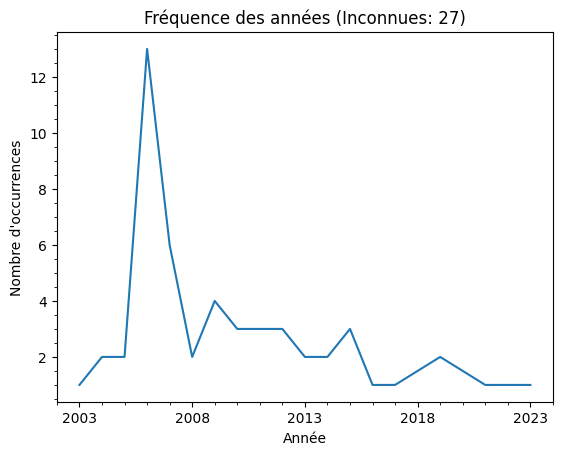

In [56]:
from pandas import json_normalize
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plot
from datetime import datetime
from pprint import pprint
import matplotlib.ticker as ticker

data = json.load(open("./metadata.json"))
image_data = []

for image_id, image_info in data.items():
  exif_tags = image_info.get("exif_tags", {})
  subject_tags = image_info.get("subject_tags")
  width = image_info.get("width")
  height = image_info.get("height")
  image_size = image_info.get("image_size")
  color_mode = image_info.get("color_mode")
  dominant_colors = image_info.get("dominant_colors", [])

  image_data.append({
      "image_id": image_id,
      "subject_tags": subject_tags,
      "width": width,
      "height": height,
      "image_size": image_size,
      "color_mode": color_mode,
      "dominant_colors": dominant_colors,
      **exif_tags  # Extraire tout le dictionnaire exif_tags
  })

df = pd.DataFrame(image_data)

years = []
unknown_years = 0
for _, subject in df.iterrows():
  date = subject["DateTime"]

  try:
    clean_date = datetime.strptime(str(date), "%Y:%m:%d %H:%M:%S")
    years.append(clean_date.year)
  except ValueError:
    unknown_years += 1

df = pd.DataFrame({'year': years})
df = df.groupby('year').size().to_frame(name='count').reset_index()


fig, ax = plot.subplots()
ax.plot(df['year'], df['count'].astype(int))
ax.set_title('Fréquence des années (Inconnues: {})'.format(unknown_years))
ax.set_xlabel('Année')
ax.set_ylabel('Nombre d\'occurrences')
ax.minorticks_on()
plot.xticks(np.arange(df['year'].min(), df['year'].max()+1, 5))

plot.show()